In [1]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score
import torch.nn.functional as F
import functools
from torch.optim import Adam
import torchvision.transforms as transforms
import os

In [2]:
# --------------------------
# Dataset 定義
# --------------------------
class PCamDataset(Dataset):
    def __init__(self, h5_x_path, h5_y_path=None, transform=None):
        self.x_path = h5_x_path
        self.y_path = h5_y_path
        self.transform = transform
        self.has_labels = h5_y_path is not None

        with h5py.File(h5_x_path, 'r') as x_file:
            self.length = len(x_file['x'])

        if self.has_labels:
            with h5py.File(h5_y_path, 'r') as y_file:
                self.labels = y_file['y'][:]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.x_path, 'r') as x_file:
            image = x_file['x'][idx].astype(np.uint8)

        image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            label = self.labels[idx].item()
            return image, label
        else:
            return image

# --------------------------
# パスと設定
# --------------------------
TRAIN_X = '/home/gotou/Medical/camelyonpatch_level_2_split_test_x.h5'
TRAIN_Y = '/home/gotou/Medical/camelyonpatch_level_2_split_train_y.h5'
VAL_X   = '/home/gotou/Medical/valid_x_uncompressed.h5'
VAL_Y   = '/home/gotou/Medical/valid_y_uncompressed.h5'
TEST_X  = '/home/gotou/Medical/camelyonpatch_level_2_split_test_x.h5'
TEST_Y  = '/home/gotou/Medical/camelyonpatch_level_2_split_test_y.h5'

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# --------------------------
# Transform
# --------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(96, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomApply([transforms.RandomSolarize(threshold=0.5, p=0.3)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])

eval_transform = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --------------------------
# Dataloader
# --------------------------
batch_size = 128
train_ds = PCamDataset(TRAIN_X, TRAIN_Y, transform=train_transform)
val_ds   = PCamDataset(VAL_X, VAL_Y, transform=eval_transform)
test_ds  = PCamDataset(TEST_X, TEST_Y, transform=eval_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)


In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# モデル構築
model = resnet50(weights=None)
model.fc = nn.Sequential(
    nn.BatchNorm1d(model.fc.in_features),  
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 1)
)
model.to(device)

# 重み読み込み
model.load_state_dict(torch.load('/home/gotou/Medical/best_resnet50_pcam.pth', map_location=device))
model.eval()

# --------------------------
# 損失関数・最適化・スケジューラ
# --------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=30)


In [4]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = criterion(outputs, labels)
    
    model.zero_grad()
    loss.backward()

    # FGSM perturbation: sign(∇_x loss)
    perturbed_images = images + epsilon * images.grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images

from sklearn.metrics import roc_auc_score

def evaluate_fgsm(loader, epsilon):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
        
        # FGSM攻撃で画像を摂動
        adv_imgs = fgsm_attack(model, imgs, labels, epsilon)

        with torch.no_grad():
            outputs = model(adv_imgs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()

            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    acc = correct / total
    auc = roc_auc_score(all_labels, all_probs)

    print(f"FGSM attack (epsilon={epsilon}) Accuracy: {acc * 100:.2f}%")
    print(f"FGSM attack (epsilon={epsilon}) ROC-AUC: {auc:.4f}")
    return acc, auc



In [5]:
epsilon = 0.3  # 摂動の強さ（適宜調整）
evaluate_fgsm(val_loader, epsilon)

FGSM attack (epsilon=0.3) Accuracy: 44.53%
FGSM attack (epsilon=0.3) ROC-AUC: 0.4276


(0.4453125, 0.4275562342261996)

In [6]:
import functools

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  10.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [7]:
import time

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]

  start = time.time()   # ←ここを追加
  score = model(perturbed_x, random_t)

  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss


In [13]:
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=500, 
               snr=0.16,                 
               device='cuda',
               eps=1e-3,
               init_x=None):
    
    t = torch.ones(batch_size, device=device)

    if init_x is None:
        init_x = torch.randn(batch_size, 3, 96, 96, device=device) * marginal_prob_std(t)[:, None, None, None]
    else:
        init_x = init_x.to(device)
        if init_x.shape[2:] != (96, 96):
            import torch.nn.functional as F
            init_x = F.interpolate(init_x, size=(96, 96), mode='bilinear', align_corners=False)
    
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    with torch.no_grad():
        for time_step in tqdm(time_steps, desc="PC Sampling"):  # ← 修正
            batch_time_step = torch.ones(batch_size, device=device) * time_step

            # Langevin MCMC (Corrector step)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            grad_norm = torch.clamp(grad_norm, min=1e-5)  # ← 数値安定化

            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2

            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            # Euler-Maruyama (Predictor step)
            g = diffusion_coeff(batch_time_step).view(-1, 1, 1, 1)
            score = score_model(x, batch_time_step)
            x_mean = x + (g ** 2) * score * step_size
            x = x_mean + torch.sqrt(g ** 2 * step_size) * torch.randn_like(x)

    return x_mean


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]

class ScoreNet(nn.Module):
  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    super().__init__()
    self.embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim)
    )
    
    self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, padding=1, bias=False)  # 入力チャネル変更
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 4, stride=2, padding=1, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

    self.tconv3 = nn.ConvTranspose2d(channels[2]+channels[2], channels[1], 4, stride=2, padding=1, bias=False)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

    self.tconv2 = nn.ConvTranspose2d(channels[1]+channels[1], channels[0], 4, stride=2, padding=1, bias=False)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

    self.tconv1 = nn.ConvTranspose2d(channels[0]+channels[0], 3, 3, stride=1, padding=1)  # 出力チャネル変更

    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t): 
    embed = self.act(self.embed(t))
    h1 = self.act(self.gnorm1(self.conv1(x) + self.dense1(embed)))
    h2 = self.act(self.gnorm2(self.conv2(h1) + self.dense2(embed)))
    h3 = self.act(self.gnorm3(self.conv3(h2) + self.dense3(embed)))
    h4 = self.act(self.gnorm4(self.conv4(h3) + self.dense4(embed)))

    h = self.act(self.tgnorm4(self.tconv4(h4) + self.dense5(embed)))
    h = self.act(self.tgnorm3(self.tconv3(torch.cat([h, h3], dim=1)) + self.dense6(embed)))
    h = self.act(self.tgnorm2(self.tconv2(torch.cat([h, h2], dim=1)) + self.dense7(embed)))
    h = self.tconv1(torch.cat([h, h1], dim=1))

    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [10]:
# -------------------------------
# モデル・関数の事前定義（省略していた場合は必要）
# → ScoreNet, marginal_prob_std_fn, loss_fn 等は定義済みと仮定
# -------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
import h5py
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tqdm
import os

class PCamDataset_k(Dataset):
    def __init__(self, x_path, y_path, transform=None):
        super().__init__()
        self.x_h5 = h5py.File(x_path, 'r')
        self.y_h5 = h5py.File(y_path, 'r')
        self.transform = transform

    def __len__(self):
        return self.x_h5['x'].shape[0]

    def __getitem__(self, idx):
        img = self.x_h5['x'][idx]
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.shape[2] == 1:
            img = np.concatenate([img]*3, axis=2)
        if self.transform:
            img = self.transform(img)
        label = self.y_h5['y'][idx]
        return img, label


# ----------- パラメータ -------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 500
batch_size = 16
lr = 2e-4
sigma = 10.0
marginal_prob_std_fn = functools.partial(lambda t, sigma: torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma)), sigma=sigma)

# ----------- モデルとデータ -------------
# データローダーの正規化を修正
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1,1]に正規化
])

dataset = PCamDataset_k(
    '/home/gotou/Medical/camelyonpatch_level_2_split_train_x.h5',
    '/home/gotou/Medical/camelyonpatch_level_2_split_train_y.h5',
    transform=transform
)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).to(device)
optimizer = Adam(score_model.parameters(), lr=lr, betas=(0.9, 0.99))
best_loss = 1000


# ----------- 損失関数 -------------
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

In [11]:
# 学習済みモデルの読み込み
score_model.load_state_dict(torch.load('/home/gotou/Medical/ckpt_epoch_1000.pth', map_location=device))
score_model.eval()

# サンプリング
samples = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                     batch_size=16, num_steps=500, device=device)


PC Sampling:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_301005/3662202757.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
PC Sampling: 100%|██████████| 500/500 [00:04<00:00, 109.79it/s]


In [56]:
import torch
from tqdm import tqdm

def purify_with_diffusion(adv_imgs, score_model, marginal_prob_std_fn, diffusion_coeff_fn, num_steps=500, device='cuda'):
    score_model.eval()
    batch_size = adv_imgs.size(0)
    with torch.no_grad():
        # 逆正規化を必ず入れる
        adv_imgs = adv_imgs * 0.5 + 0.5
        adv_imgs = torch.clamp(adv_imgs, 0., 1.)
        
        purified = pc_sampler(
            score_model,
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            batch_size=batch_size,
            num_steps=num_steps,
            device=device,
            init_x=adv_imgs
        )
        purified = torch.clamp(purified, 0., 1.)
    return purified


def evaluate_fgsm_with_diffusion(val_loader, model, score_model,
                                marginal_prob_std_fn, diffusion_coeff_fn,
                                epsilon=0.3, device='cuda'):
    """
    val_loaderのデータに対しFGSM攻撃→拡散モデルで復元→分類器で推論→評価＋画像可視化用に返す
    """
    model.eval()
    score_model.eval()

    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    # 画像保存用
    all_imgs = []
    all_adv = []
    all_purified = []
    all_preds = []

    for i, (imgs, labels) in enumerate(tqdm(val_loader)):
        if i >= 1:  # 最初の1バッチだけ実行
            break

        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        adv_imgs = fgsm_attack(model, imgs, labels, epsilon)
        purified_imgs = purify_with_diffusion(adv_imgs, score_model, marginal_prob_std_fn, diffusion_coeff_fn, device=device)

        with torch.no_grad():
            outputs = model(purified_imgs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()

        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        all_imgs.append(imgs.cpu())
        all_adv.append(adv_imgs.cpu())
        all_purified.append(purified_imgs.cpu())

    acc = correct / total
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(all_labels, all_probs)

    print(f"FGSM (ε={epsilon}) + Diffusion Purify Accuracy: {acc*100:.2f}%")
    print(f"FGSM (ε={epsilon}) + Diffusion Purify ROC-AUC: {auc:.4f}")

    return acc, auc, torch.cat(all_imgs), torch.cat(all_adv), torch.cat(all_purified), np.array(all_labels), np.array(all_preds)



In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 通常 Normalize(mean=0.5, std=0.5) を使っていたなら以下
def unnormalize(img, mean=0.5, std=0.5):
    return img * std + mean


def show_images_with_matrix(original_imgs, adv_imgs, purified_imgs, labels, preds, class_names=['Negative', 'Positive'], index=0):
    def preprocess(img):
        img = img.detach().cpu()
        img = unnormalize(img)  # 逆正規化を追加
        return torch.clamp(img, 0., 1.).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(preprocess(original_imgs[index]))
    axs[0].set_title("Original")
    axs[1].imshow(preprocess(adv_imgs[index]))
    axs[1].set_title("Adversarial")
    axs[2].imshow(preprocess(purified_imgs[index]))
    axs[2].set_title("Purified")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()



In [94]:
import matplotlib.pyplot as plt
import numpy as np

def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=1000, 
               snr=0.001,                 
               device='cuda',
               eps=1e-3,
               init_x=None):
    
    t = torch.ones(batch_size, device=device)

    if init_x is None:
        init_x = torch.randn(batch_size, 3, 96, 96, device=device) * marginal_prob_std(t)[:, None, None, None]
    else:
        init_x = init_x.to(device)
        if init_x.shape[2:] != (96, 96):
            import torch.nn.functional as F
            init_x = F.interpolate(init_x, size=(96, 96), mode='bilinear', align_corners=False)

    # ステップを等間隔でとる
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    # 保存用リスト
    x_mean_history = {}

    with torch.no_grad():
        for i, time_step in enumerate(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step

            # Langevin MCMC (Corrector step)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            grad_norm = torch.clamp(grad_norm, min=1e-5)

            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2

            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            # Euler-Maruyama (Predictor step)
            g = diffusion_coeff(batch_time_step).view(-1, 1, 1, 1)
            score = score_model(x, batch_time_step)
            x_mean = x + (g ** 2) * score * step_size
            x = x_mean + torch.sqrt(g ** 2 * step_size) * torch.randn_like(x)

            # 指定ステップの画像を保存（x_mean）
            if i in [450, 460, 470, 480, 490, 499]:
                x_mean_history[i] = x_mean[0].detach().cpu()

    # 可視化
    for step in sorted(x_mean_history.keys()):
        img = x_mean_history[step]
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"x_mean at Step {step}")
        plt.axis('off')
        plt.show()

    return x_mean


  0%|          | 0/256 [00:00<?, ?it/s]/tmp/ipykernel_301005/3662202757.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


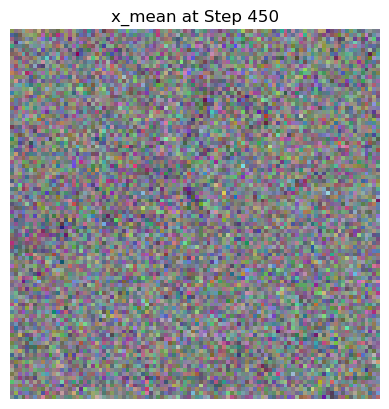

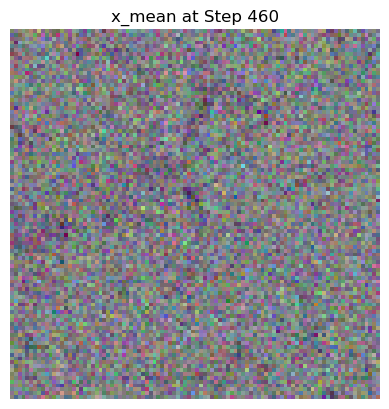

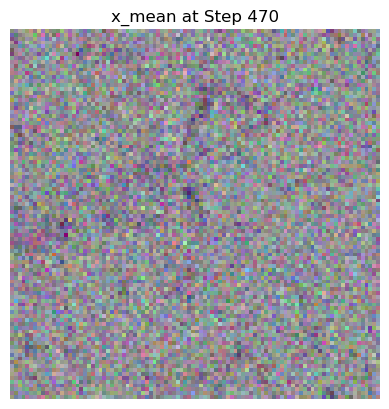

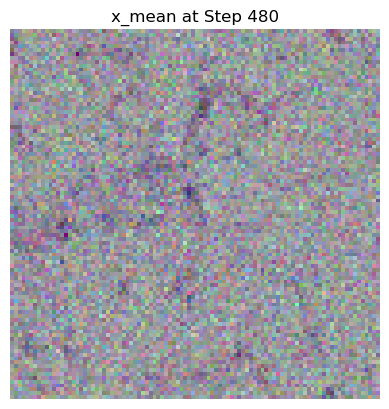

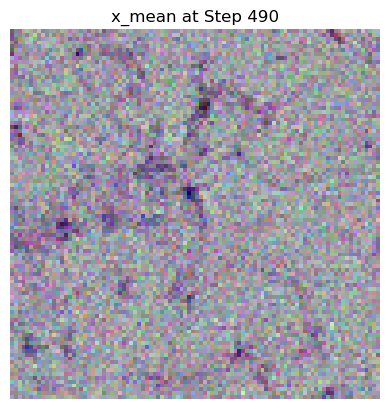

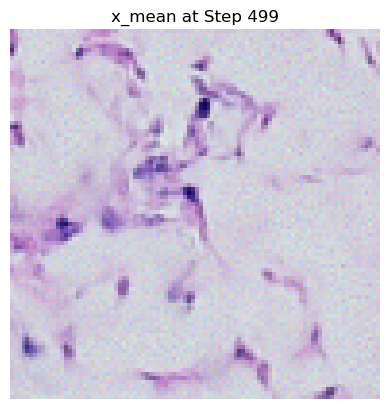

  0%|          | 1/256 [00:33<2:20:51, 33.14s/it]

FGSM (ε=0.03) + Diffusion Purify Accuracy: 35.16%
FGSM (ε=0.03) + Diffusion Purify ROC-AUC: 0.6059


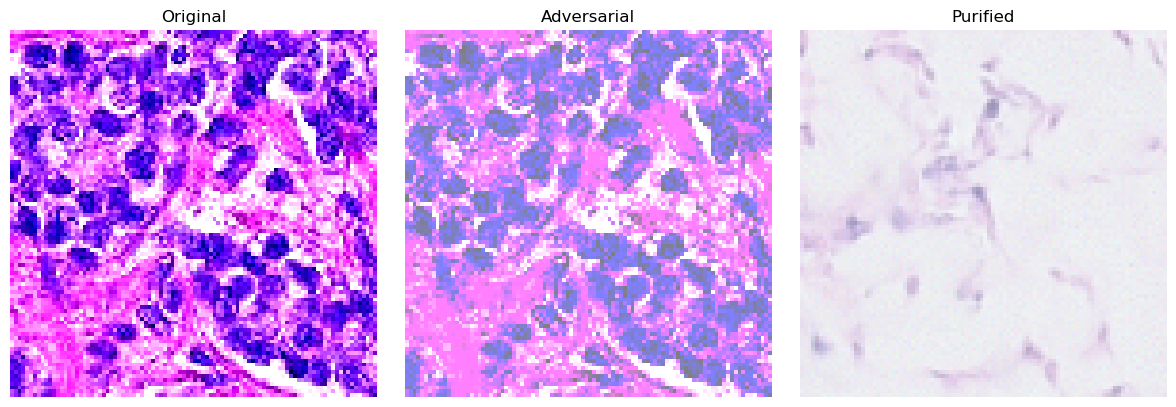

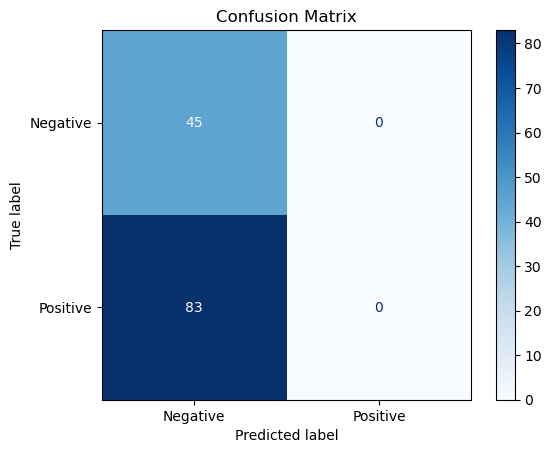

In [95]:
acc, auc, original_imgs, adv_imgs, purified_imgs, labels, preds = evaluate_fgsm_with_diffusion(
    val_loader, model, score_model, marginal_prob_std_fn, diffusion_coeff_fn, epsilon, device
)

# 0番目の画像で表示（任意に index 変更可能）
show_images_with_matrix(original_imgs, adv_imgs, purified_imgs, labels, preds, index=0)


In [32]:
x = torch.rand(1, 3, 96, 96).to(device)
t = torch.tensor([0.5], device=device)
score = score_model(x, t)
print("score mean:", score.mean().item(), "std:", score.std().item())


score mean: 0.008707281202077866 std: 0.19551226496696472
